In [1]:
from datasets import SOCOFingEncoder
from FPMLmodule.backbones import ResNet50
from FPMLmodule.classifiers import ResNetClassifier
from FPMLmodule.fpml import FPML 
from FPMLmodule.utils import displayDsSamples, displayDsSplit, displayTrainProgress, displayConfusion
import numpy as np
from matplotlib import pyplot as plt
# from keras import layers, Sequential, models
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

from tensorflow.keras import layers, Sequential
from tensorflow import keras

Tensorflow version 2.8.0


In [2]:
# Global Config
seed=9
img_dim = (120, 120, 3)
img_height, img_width, img_channels = img_dim
batch_size = 32

# Dataset configuration

AUTOTUNE = tf.data.AUTOTUNE
split_ratio = [0.7, 0.3]
shuffle=True
dsConfig = {
    'batchSize': batch_size, 
    'parallelTune': AUTOTUNE, 
    'split': split_ratio, 
    'inputDim': img_dim, 
    'seed': seed, 
    'shuffle': shuffle
    }

# Model Config
learning_rate = 0.001
epochs_find_best = 10
epochs_best = 100


In [3]:
SOCOEncoder = SOCOFingEncoder(**dsConfig)
train_set, test_set = SOCOEncoder.create()

Metal device set to: AMD Radeon Pro 5500M

systemMemory: 16.00 GB
maxCacheSize: 1.99 GB



2022-04-28 08:35:41.750527: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-28 08:35:41.751733: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-28 08:35:41.752014: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
#  Normalization and shape fix
def preprocess(array):

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array

# noising data by adding gaussian noise to every picture
def add_noise(array, factor):

    noisy_array = array + factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

# display n images of digits, for every image plot clear and noisy pictures
def display(array1, array2, array3, n):

    # choose n indices randomly
    indices = np.random.randint(len(array1), size=n)
    # select the pictures from any set
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    images3 = array3[indices, :]

    # plot n*3 images
    plt.figure(figsize=(20, 4))
    for i, (image1, image2, image3) in enumerate(zip(images1, images2, images3)):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.title('Original')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.title('Noisy')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(image3.reshape(28, 28))
        plt.title('After Clearing')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [13]:
encoder = Sequential(
    [
    # Encoder
        layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer="glorot_uniform"), #118
        layers.MaxPooling2D((2, 2)), #59
        layers.BatchNormalization(axis=3),
        layers.Conv2D(32, (4, 4), activation="relu", kernel_initializer="glorot_uniform"), #57
        layers.MaxPooling2D((2, 2)), #28
        tf.keras.layers.BatchNormalization(axis=3),
        layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="glorot_uniform"), #26
        # layers.MaxPooling2D((2, 2)), #3
        ], name="encoder"
    )

decoder = Sequential(
    [
        # Decoder
        # layers.UpSampling2D((2, 2)), #10
        # layers.Conv2DTranspose(64, (3, 3), activation="relu", kernel_initializer="glorot_uniform"), #5
        layers.Conv2DTranspose(32, (3, 3), activation="relu", kernel_initializer="glorot_uniform"), #12
        layers.UpSampling2D((2, 2)), #10
        layers.Conv2DTranspose(16, (4, 4), activation="relu", kernel_initializer="glorot_uniform"), #26
        layers.UpSampling2D((2, 2)), #60
        layers.Conv2DTranspose(3, (3, 3), activation="sigmoid", kernel_initializer="glorot_uniform"), #120
    ], name="decoder"
    )

autoencoder = Sequential([
    encoder,
    decoder
], name="autoencoder")

# Selecting Adam as optimizer
autoencoder.compile(optimizer="adam", loss="mean_squared_error", metrics=['accuracy'])
autoencoder.build((None, 120, 120, 3))
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 26, 26, 64)        27360     
                                                                 
 decoder (Sequential)        (None, 120, 120, 3)       27107     
                                                                 
Total params: 54,467
Trainable params: 54,371
Non-trainable params: 96
_________________________________________________________________


In [6]:
# encoder_input = keras.Input(shape=(120, 120, 3), name="img")
# x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
# x = layers.Conv2D(32, 3, activation="relu")(x)
# x = layers.MaxPooling2D(3)(x)
# x = layers.Conv2D(32, 3, activation="relu")(x)
# x = layers.Conv2D(16, 3, activation="relu")(x)
# encoder_output = layers.GlobalMaxPooling2D()(x)

# encoder = keras.Model(encoder_input, encoder_output, name="encoder")
# encoder.summary()

# x = layers.Reshape((4, 4, 1))(encoder_output)
# x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
# x = layers.UpSampling2D(3)(x)
# x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
# decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

# autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
# autoencoder.summary()

In [9]:
img_file = './model_arch.png'
tf.keras.utils.plot_model(autoencoder, to_file=img_file, show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [10]:
for batch in train_set:
    print(batch[0].numpy().shape, batch[1].numpy().shape)
    break

(32, 120, 120, 3) (32, 120, 120, 3)


In [14]:
# Train with validation
history = autoencoder.fit(
    x=train_set,
    # batch_size=32,
    epochs=10,
)

Epoch 1/10


2022-04-25 17:40:16.962979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 18s 132ms/step - loss: 28896.2832 - accuracy: 0.9264
Epoch 2/10
132/132 [==============================] - 17s 129ms/step - loss: 28893.1738 - accuracy: 0.9599
Epoch 3/10
132/132 [==============================] - 18s 133ms/step - loss: 28893.1582 - accuracy: 0.9650
Epoch 4/10
132/132 [==============================] - 18s 137ms/step - loss: 28893.1582 - accuracy: 0.9668
Epoch 5/10
132/132 [==============================] - 16s 121ms/step - loss: 28893.1602 - accuracy: 0.9684
Epoch 6/10
132/132 [==============================] - 16s 120ms/step - loss: 28893.1582 - accuracy: 0.9707
Epoch 7/10
132/132 [==============================] - 16s 121ms/step - loss: 28893.1660 - accuracy: 0.9737
Epoch 8/10
132/132 [==============================] - 16s 121ms/step - loss: 28893.1641 - accuracy: 0.9781
Epoch 9/10
132/132 [==============================] - 17s 129ms/step - loss: 28893.1621 - accuracy: 0.9739
Epoch 10/10
132/132 [===========================

In [15]:
predicted = autoencoder.predict(test_set)

2022-04-25 17:43:38.080848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


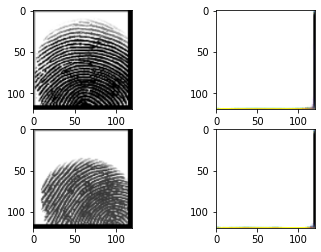

In [19]:
for (batch, _) in test_set:
    plt.subplot(2, 2, 1)
    plt.imshow(batch[0])
    
    plt.subplot(2, 2, 2)
    plt.imshow(predicted[0])
    plt.subplot(2, 2, 3)
    plt.imshow(batch[1])
    
    plt.subplot(2, 2, 4)
    plt.imshow(predicted[1])
    plt.show()
    break